In [1]:
import os, sys
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
print("Project root added to sys.path:", ROOT)

from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
import jax.numpy as jnp
from utils.artifacts_io import latest_run_dir, load_manifest, npz, list_widths
from notebooks.utils_plotting import plot_regression_convergence, print_run_config

Project root added to sys.path: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments


# Eigen values trajectories

In [2]:
BASE = "../results"; EXP = "ntk_spectrum_drift"
RUN = latest_run_dir(BASE, EXP)

In [3]:
man = load_manifest(RUN)
print(man["meta"])
man

{'widths': [100, 512, 1024, 2048, 10000], 'seeds': 5, 'steps': 100000, 'lr': 1.0, 'eval_every': 500, 'depth_hidden': 1}


{'probe_geometry': 'probe_geometry.npz',
 'training_task': 'training_task.npz',
 'runs': {'100': 'runs/width_100.npz',
  '512': 'runs/width_512.npz',
  '1024': 'runs/width_1024.npz',
  '2048': 'runs/width_2048.npz',
  '10000': 'runs/width_10000.npz'},
 'meta': {'widths': [100, 512, 1024, 2048, 10000],
  'seeds': 5,
  'steps': 100000,
  'lr': 1.0,
  'eval_every': 500,
  'depth_hidden': 1},
 'runtime_sec': 1406.39}

In [4]:
def plot_preds_spread_for_widths_at_step(run_dir, man, step, q_low=10, q_high=90):
    """
    Plot mean +- spread of predictions across seeds for a single training step.
    """
    data = npz(run_dir, man["probe_geometry"])
    gamma_eval = data["gamma"]
    y_eval_true = data["y_eval"]

    plt.figure(figsize=(10, 4))
    plt.plot(
        gamma_eval, y_eval_true, color="gray", alpha=0.6, label="f$^*(\gamma)$ on circle"
    )

    widths_all = sorted(int(w) for w in man["runs"].keys())
    for width in widths_all:
        block = npz(run_dir, man["runs"][str(width)])
        preds = block["preds"]              # (T, 720)
        meta  = block["preds_meta"]         # (T, 2): (seed, step)

        mask = (meta[:, 1] == step)
        pred_group = preds[mask]            # (num_seeds=5, 720)

        mean_pred = pred_group.mean(axis=0)
        lo, hi = np.percentile(pred_group, [q_low, q_high], axis=0)

        plt.plot(gamma_eval, mean_pred, label=f"w={width}")
        plt.fill_between(gamma_eval, lo, hi, alpha=0.25, color="C0")

    plt.xlabel(r"angle $\gamma$")
    plt.ylabel("f(x)")
    plt.title(f"Predictions at step={step} (mean ± spread over seeds)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

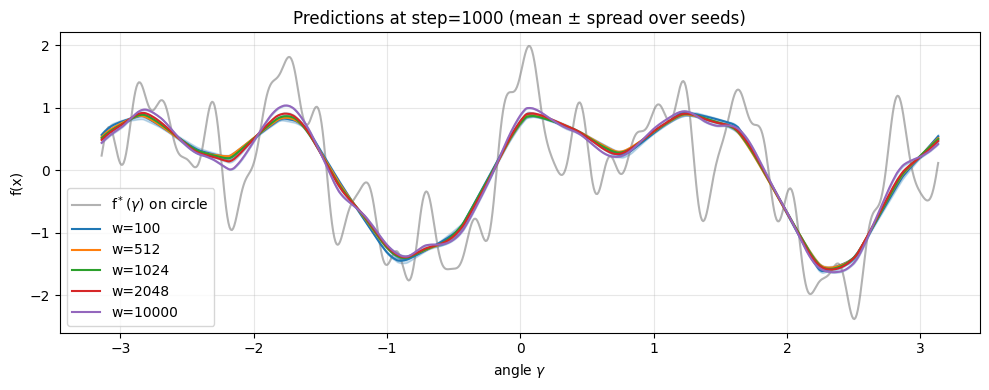

In [7]:
plot_preds_spread_for_widths_at_step(RUN, man, step=1000, q_low=10, q_high=90)

In [5]:
def get_all_steps(man, run_dir):
    width_any = next(iter(man["runs"].keys()))
    block = npz(run_dir, man["runs"][width_any])
    meta = block["preds_meta"]
    steps = np.unique(meta[:, 1])
    return np.sort(steps)   # (201,)

def compute_mean_spread_for_all_widths(run_dir, man, q_low=10, q_high=90):
    steps = get_all_steps(man, run_dir)
    widths = sorted(int(w) for w in man["runs"].keys())

    results = {}  # width -> dict(step -> (mean, lo, hi))

    for width in widths:
        block = npz(run_dir, man["runs"][str(width)])
        preds = block["preds"]
        meta  = block["preds_meta"]

        width_dict = {}
        for step in steps:
            mask = (meta[:, 1] == step)
            pred_group = preds[mask]  # (5, 720)

            mean_pred = pred_group.mean(axis=0)
            lo, hi = np.percentile(pred_group, [q_low, q_high], axis=0)

            width_dict[int(step)] = (mean_pred, lo, hi)

        results[width] = width_dict

    return steps, widths, results

In [9]:
from matplotlib.animation import FuncAnimation, PillowWriter

def animate_pred_spread(run_dir, man, target=None, q_low=10, q_high=90, save_path="preds_anim.gif"):
    data = npz(run_dir, man["probe_geometry"])
    gamma_eval = data["gamma"]
    y_true = data["y_eval"]

    # Precompute means & spreads
    steps, widths_all, results = compute_mean_spread_for_all_widths(
        run_dir, man, q_low, q_high
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_xlabel(r"angle $\gamma$")
    ax.set_ylabel("f*(x)")
    ax.grid(alpha=0.3)

    # Plot target once
    if target is None:
        target_line, = ax.plot(gamma_eval, y_true, color="gray", alpha=0.6, label="f*(γ)")
    else:
        target_line = ax.plot(gamma_eval, target, color="gray", alpha=0.6, label="f*(γ) (partial)")

    # Choose stable colors for each width from Matplotlib's cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    width_colors = {w: color_cycle[i % len(color_cycle)]
                    for i, w in enumerate(widths_all)}

    # Create visible lines (fixed artists)
    width_lines = {}
    width_bands = {}  # store the PolyCollection for each width

    for w in widths_all:
        color = width_colors[w]
        line, = ax.plot([], [], label=f"w={w}", color=color)
        width_lines[w] = line
        width_bands[w] = None  # placeholder for the band

    ax.legend()  # legend stays forever

    # --- INIT ---
    def init():
        for w in widths_all:
            width_lines[w].set_data([], [])
        return list(width_lines.values()) + [target_line]

    # --- UPDATE ---
    def update(frame_idx):
        step = int(steps[frame_idx])
        artists = []

        for w in widths_all:
            mean_pred, lo, hi = results[w][step]
            color = width_colors[w]

            # Update line
            width_lines[w].set_data(gamma_eval, mean_pred)
            artists.append(width_lines[w])

            # Remove previous band
            if width_bands[w] is not None:
                width_bands[w].remove()

            # Create new band (stable color!)
            band = ax.fill_between(gamma_eval, lo, hi,
                                   alpha=0.2,
                                   color=color)
            width_bands[w] = band
            artists.append(band)

        ax.set_title(f"Prediction evolution - step {step}")

        return artists + [target_line]

    anim = FuncAnimation(
        fig, update, frames=len(steps),
        init_func=init, blit=False, interval=80
    )

    anim.save(save_path, writer=PillowWriter(fps=10))
    print(f"Saved animation to {save_path}")



In [ ]:
animate_pred_spread(RUN, man, q_low=10, q_high=90, save_path="preds_spread.gif")

In [ ]:
from core.data import make_fourier_target, f_star_gamma_partial

Ks = [2, 4, 7, 11, 16, 23, 32]
amps = [0.9, 0.7, 0.55, 0.45, 0.35, 0.28, 0.22]
phases = [0.0, 1.57079632679, 1.2, 2.0, 0.942, 4.5, 5.8] 
spec = make_fourier_target(Ks, amps, phases)

k = 2
data = npz(RUN, man["probe_geometry"])
gamma_eval = data["gamma"]
target = f_star_gamma_partial(gamma_eval, spec, k)

animate_pred_spread(RUN, man, target=target, q_low=10, q_high=90, save_path=f"preds_spread_{k}_harmonics.gif")

In [6]:
def plot_topk_eigenvalues_spread_for_width(run_dir, man, width, k=5,
                                           q_low=10, q_high=90):
    """
    For a fixed width, plot top-k NTK eigenvalues over training,
    showing mean and spread (quantile band) across seeds.
    """
    block = npz(run_dir, man["runs"][str(width)])
    spectra = block["spectra"]            # (T, M)
    meta    = block["spectra_meta"]       # (T, 2): (seed, step)

    steps_unique = np.unique(meta[:, 1])
    steps_unique = np.sort(steps_unique)

    # Each will become (T_steps, k)
    topk_mean = []
    topk_lo   = []
    topk_hi   = []

    for step in steps_unique:
        mask = (meta[:, 1] == step)
        vals = spectra[mask]              # (num_seeds, M)

        # sort eigenvalues descending per seed
        vals_sorted = np.sort(vals, axis=1)[:, ::-1]  # (num_seeds, M)
        topk_vals = vals_sorted[:, :k]                # (num_seeds, k)

        topk_mean.append(topk_vals.mean(axis=0))
        q_lo, q_hi = np.percentile(topk_vals, [q_low, q_high], axis=0)
        topk_lo.append(q_lo)
        topk_hi.append(q_hi)

    topk_mean = np.asarray(topk_mean)  # (T_steps, k)
    topk_lo   = np.asarray(topk_lo)
    topk_hi   = np.asarray(topk_hi)

    plt.figure(figsize=(8, 5))

    for i in range(k):
        mu = topk_mean[:, i]
        lo = topk_lo[:, i]
        hi = topk_hi[:, i]

        label = rf"$\lambda_{i+1}$"
        plt.plot(steps_unique, mu, label=label)
        plt.fill_between(steps_unique, lo, hi, alpha=0.2)

    plt.title(f"Top-{k} NTK eigenvalues (mean ± spread across seeds, width={width})")
    plt.xlabel("Training step")
    plt.ylabel("Eigenvalue")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

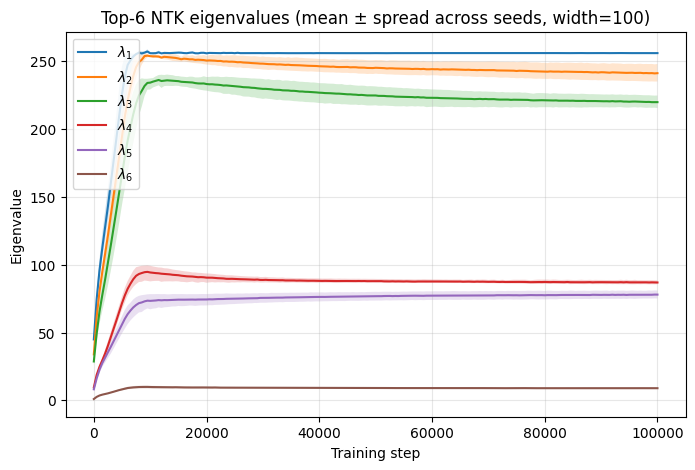

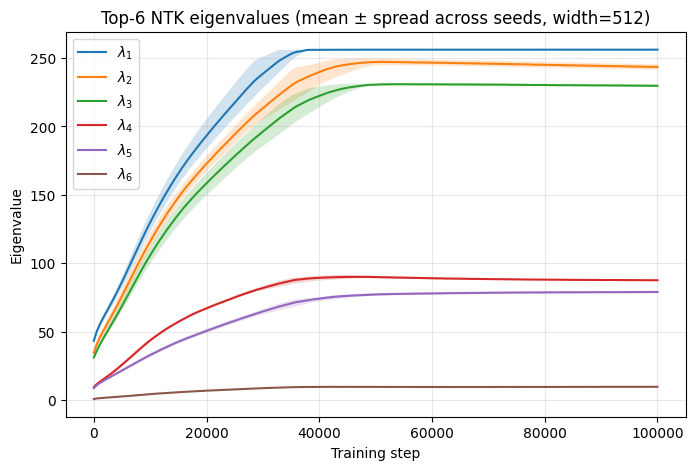

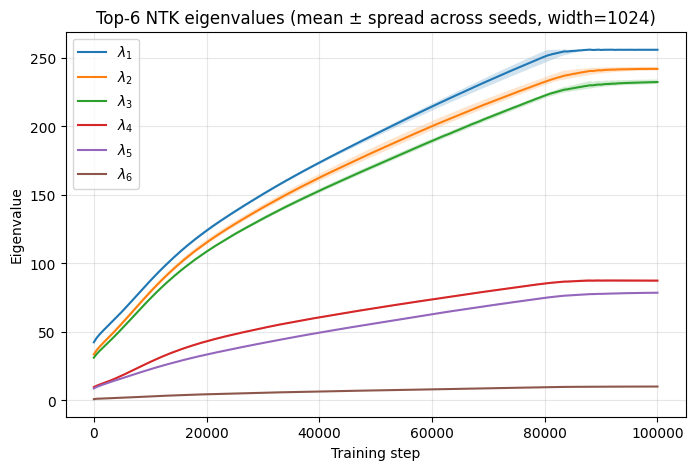

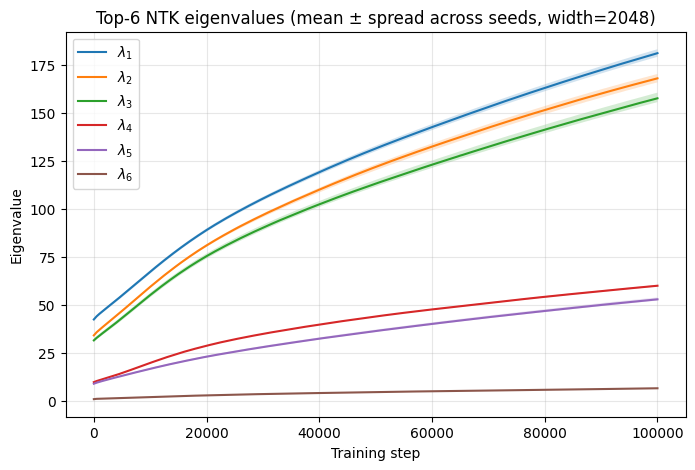

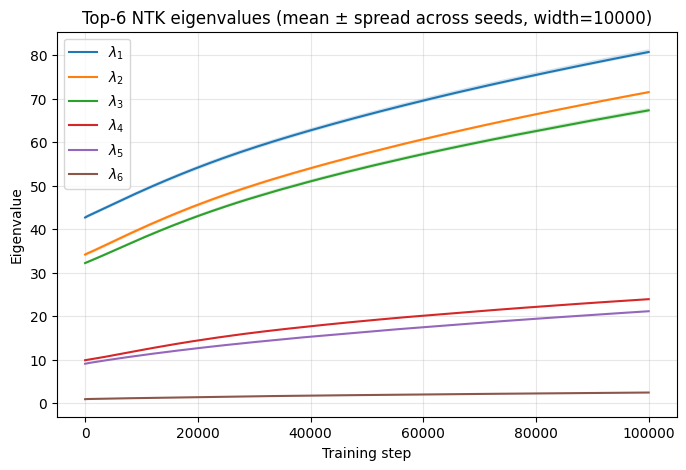

In [7]:
widths_all = sorted(int(w) for w in man["runs"].keys())
for w in widths_all:
    plot_topk_eigenvalues_spread_for_width(RUN, man, w, k=6)

In [14]:
def plot_last_k_eigenvalues_spread_for_width(run_dir, man, width, k=5,
                                           q_low=10, q_high=90):
    """
    For a fixed width, plot last-k NTK eigenvalues over training,
    showing mean and spread (quantile band) across seeds.
    """
    block = npz(run_dir, man["runs"][str(width)])
    spectra = block["spectra"]            # (T, M)
    meta    = block["spectra_meta"]       # (T, 2): (seed, step)

    steps_unique = np.unique(meta[:, 1])
    steps_unique = np.sort(steps_unique)

    # Each will become (T_steps, k)
    last_k_mean = []
    last_k_lo   = []
    last_k_hi   = []

    for step in steps_unique:
        mask = (meta[:, 1] == step)
        vals = spectra[mask]              # (num_seeds, M)

        # sort eigenvalues descending per seed
        vals_sorted = np.sort(vals, axis=1)  # (num_seeds, M)
        last_k_vals = vals_sorted[:, :k]                # (num_seeds, k)

        last_k_mean.append(last_k_vals.mean(axis=0))
        q_lo, q_hi = np.percentile(last_k_vals, [q_low, q_high], axis=0)
        last_k_lo.append(q_lo)
        last_k_hi.append(q_hi)

    last_k_mean = np.asarray(last_k_mean)  # (T_steps, k)
    last_k_lo   = np.asarray(last_k_lo)
    last_k_hi   = np.asarray(last_k_hi)

    plt.figure(figsize=(8, 5))

    for i in range(k):
        mu = last_k_mean[:, i]
        lo = last_k_lo[:, i]
        hi = last_k_hi[:, i]

        label = rf"$\lambda_{i+1}$"
        plt.plot(steps_unique, mu, label=label)
        plt.fill_between(steps_unique, lo, hi, alpha=0.2)

    plt.title(f"Last-{k} NTK eigenvalues (mean ± spread across seeds, width={width})")
    plt.xlabel("Training step")
    plt.ylabel("Eigenvalue")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

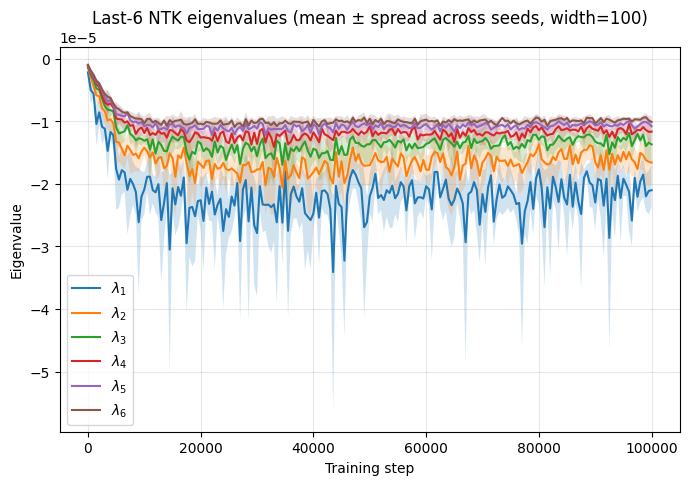

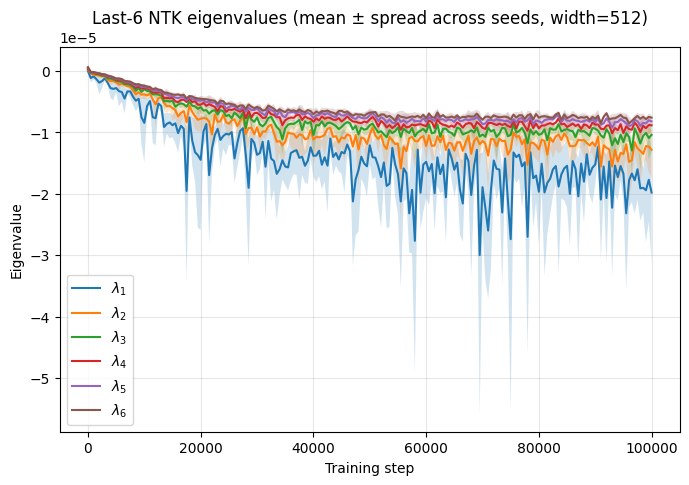

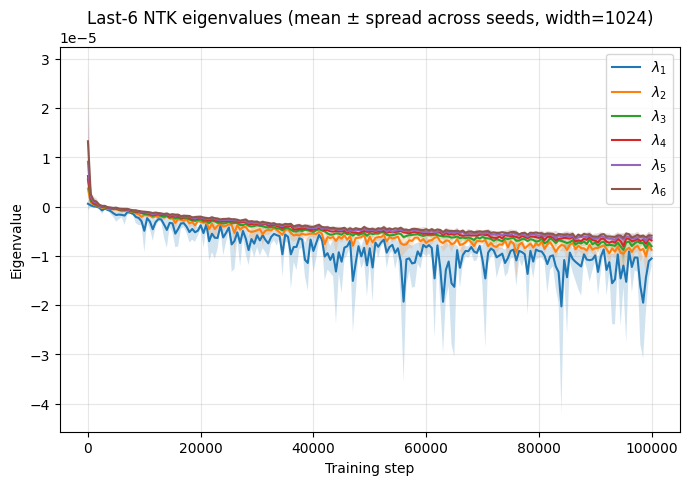

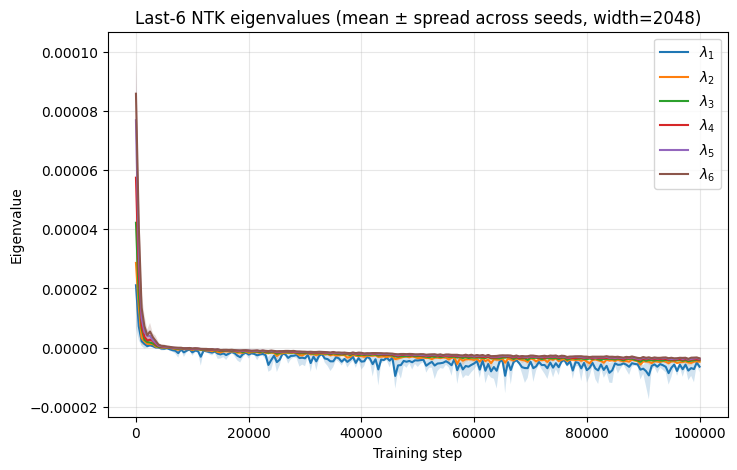

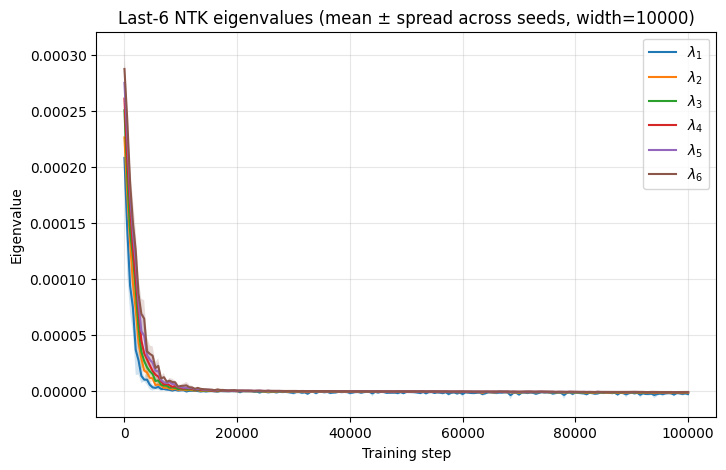

In [15]:
for w in widths_all:
    plot_last_k_eigenvalues_spread_for_width(RUN, man, w, k=6) 

In [28]:
def spectrum_stats_over_seeds(run_dir, man, width, q_low=10, q_high=90):
    """
    For a fixed width, compute mean + percentile bands of the spectrum
    across seeds at each training step.
    """
    block   = npz(run_dir, man["runs"][str(width)])
    spectra = block["spectra"]       # (T_total, M)
    meta    = block["spectra_meta"]  # (T_total, 2): (seed, step)

    steps_unique = np.sort(np.unique(meta[:, 1]))
    s_mean, s_lo, s_hi = [], [], []

    for step in steps_unique:
        mask = (meta[:, 1] == step)
        vals = spectra[mask]              # (num_seeds, M)

        # sort eigenvalues per seed
        vals_sorted = np.sort(vals, axis=1)[:, ::-1]  # (num_seeds, M)

        # stats
        s_mean.append(vals_sorted.mean(axis=0))
        lo, hi = np.percentile(vals_sorted, [q_low, q_high], axis=0)
        s_lo.append(lo)
        s_hi.append(hi)

    return steps_unique, np.asarray(s_mean), np.asarray(s_lo), np.asarray(s_hi)

    
def plot_spectrum_drift(run_dir, man, widths, ref_step_index=0):
    plt.figure(figsize=(6, 4))

    for width in widths:
        steps, s_mean, s_lo, s_hi = spectrum_stats_over_seeds(run_dir, man, width)

        ref = s_mean[ref_step_index]
        ref_norm = np.linalg.norm(ref)

        drift_mean = np.linalg.norm(s_mean - ref, axis=1) / ref_norm
        drift_lo   = np.linalg.norm(s_lo   - ref, axis=1) / ref_norm
        drift_hi   = np.linalg.norm(s_hi   - ref, axis=1) / ref_norm

        # plot mean drift
        plt.plot(steps, drift_mean, label=f"w={width}")

        # plot spread as shaded region
        plt.fill_between(steps, drift_lo, drift_hi, alpha=0.2)

    plt.xlabel("Training step")
    plt.ylabel("Relative spectral drift")
    plt.title("Full-spectrum drift (mean ± spread across seeds)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


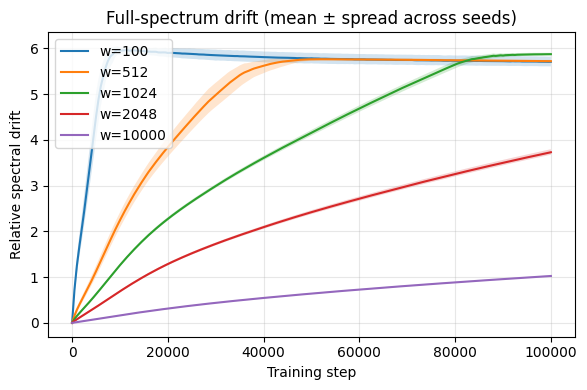

In [29]:
plot_spectrum_drift(RUN, man, widths_all)

In [40]:
def plot_spectrum_variance(run_dir, man, widths, q_low=10, q_high=90):
    """
    Plot the variance (second moment) of the eigenvalues over time,
    with percentile bands across seeds.
    """
    plt.figure(figsize=(6, 4))

    for width in widths:
        steps, s_mean, s_lo, s_hi = spectrum_stats_over_seeds(
            run_dir, man, width, q_low=q_low, q_high=q_high
        )

        # variance across eigenvalues (axis=1 = over eigenvalue index)
        var_mean = np.var(s_mean, axis=1)
        var_lo   = np.var(s_lo, axis=1)
        var_hi   = np.var(s_hi, axis=1)

        plt.plot(steps, var_mean, label=f"w={width}")
        plt.fill_between(steps, var_lo, var_hi, alpha=0.2)

    plt.xlabel("Training step")
    plt.ylabel("Variance of eigenvalues")
    plt.title("Full-spectrum drift (variance ± spread across seeds)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


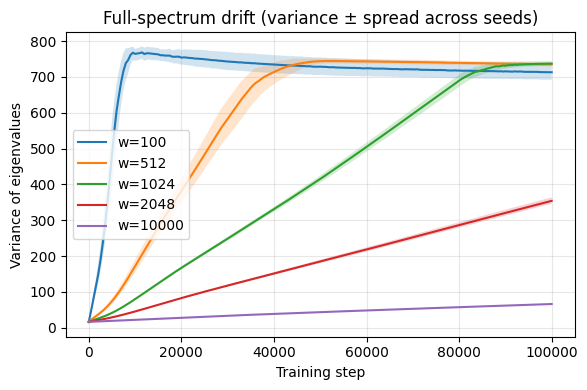

In [41]:
plot_spectrum_variance(RUN, man, widths_all)

In [16]:
def total_variation_absolute(mean_spectra):
    """
    mean_spectra: (T_steps, M)
    Returns:
        TV: (M,) absolute total variation per eigenvalue index j
    """
    T, M = mean_spectra.shape
    TV = np.zeros(M)

    for j in range(M):
        lam = mean_spectra[:, j]        # (T,)
        diffs = np.abs(lam[1:] - lam[:-1])
        TV[j] = np.sum(diffs)

    return TV


def count_active_modes(TV, tau=None, quantile=None):
    """
    TV        : (M,)
    tau       : absolute TV threshold (optional)
    quantile  : use a quantile for tau, e.g. 0.9, 0.95 (optional)

    Returns:
        N_active, tau_used
    """
    if quantile is not None:
        tau_used = np.quantile(TV, quantile)
    else:
        tau_used = tau

    active = (TV > tau_used)
    return active.sum(), tau_used


def analyze_spectrum_TV_absolute(run_dir, man, widths, tau=None, quantile=None):
    """
    Returns dict: width -> (TV_vector, N_active, tau_used)
    """
    results = {}

    for w in widths:
        steps, mean_spectra = mean_spectrum_over_seeds(run_dir, man, w)
        TV = total_variation_absolute(mean_spectra)
        N_active, tau_used = count_active_modes(TV, tau=tau, quantile=quantile)

        print(f"width={w}: active modes = {N_active}  (tau={tau_used:.4e})")

        results[w] = (TV, N_active, tau_used)

    return results


def plot_active_modes(results):
    widths = sorted(results.keys())
    N = [results[w][1] for w in widths]

    plt.figure(figsize=(6,4))
    plt.plot(widths, N, marker='o')
    plt.xlabel("Width")
    plt.ylabel("Active eigenvalue count")
    plt.title("Number of active NTK eigen-modes vs Width")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_TV_distribution(TV, width, tau_used):
    plt.figure(figsize=(7,4))
    plt.plot(TV, marker='.', linestyle='None')
    plt.axhline(tau_used, color='red', linestyle='--', label=f"threshold={tau_used:.3e}")
    plt.xlabel("Eigenvalue index (sorted)")
    plt.ylabel("Absolute Total Variation (TV)")
    plt.title(f"TV per eigenvalue (width={width})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

width=100: active modes = 22  (tau=1.0000e+00)
width=512: active modes = 19  (tau=1.0000e+00)
width=1024: active modes = 17  (tau=1.0000e+00)
width=2048: active modes = 13  (tau=1.0000e+00)
width=10000: active modes = 7  (tau=1.0000e+00)


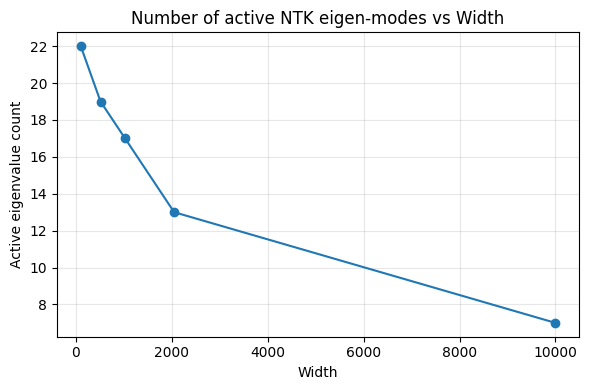

In [17]:
tau = 1
results = analyze_spectrum_TV_absolute(RUN, man, widths_all, tau=tau)
plot_active_modes(results)